In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import tqdm
import json
%matplotlib inline

from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} will be used for training...")

cuda will be used for training...


In [3]:
train_data_path = os.path.join("..", "dataset", "data", "train")
valid_data_path = os.path.join("..", "dataset", "data", "valid")
test_data_path = os.path.join("..", "dataset", "data", "test")
print(f"Train path: {train_data_path}\nValid path: {valid_data_path}\nTrain Path: {train_data_path}")

Train path: ..\dataset\data\train
Valid path: ..\dataset\data\valid
Train Path: ..\dataset\data\train


# 1. Defining Transforms for Data Augumentation

In [4]:
image_size = 256
batch_size = 32

train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize([0, 0, 0], [1, 1, 1]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(256),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [5]:
training_data = ImageFolder(train_data_path, transform=train_transforms)
valid_data = ImageFolder(valid_data_path, transform=test_transforms)
test_data = ImageFolder(test_data_path, transform=test_transforms)

In [6]:
def make_weights_for_balanced_classes(images, nclasses):
    # n_images = len(images)

    # print("Counting class frequencies", flush=True)
    # count_per_class = Counter(image_class for _, image_class in tqdm.tqdm(images))
    # print(f"Counts: {count_per_class}", flush=True)

    print("Calculating weights...", flush=True)
    weight_per_class = {0: 1.1948951686, 1: 6.1309635173}

    print("Assigning weights...", flush=True)
    weights = [weight_per_class[image_class] for _, image_class in tqdm.tqdm(images)]

    return weights

In [7]:
if os.path.exists("weights.json"):
    with open("weights.json", "r") as f:
        weights = json.load(f)["weights"]
else:
    weights = make_weights_for_balanced_classes(training_data, 2)

In [8]:
set(weights)

{1.1948951686, 6.1309635173}

In [9]:
if not os.path.exists("weights.json"):
    class_weights_path = "./weights.json"
    class_weights = {"weights": weights}

    with open(class_weights_path, "w") as file:
        json.dump(class_weights, file)

In [10]:
from torch.utils.data.sampler import WeightedRandomSampler

weights = torch.DoubleTensor(weights)
training_sampler = WeightedRandomSampler(weights, len(weights))

In [11]:
train_loader = DataLoader(training_data, batch_size=batch_size, sampler=training_sampler)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [12]:
idx_to_class = {v: k for k, v in training_data.class_to_idx.items()}
idx_to_class

{0: 'fake', 1: 'real'}

In [13]:
def display_image(img_tensor, title=None):
  image = img_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image
  # image = image.clip(0, 1)

  if title:
    plt.title(title)

  plt.imshow(image)
  plt.show()

def plot_double_line(x, y1, y2, title="", y1label="", y2label="", xlab="", ylab=""):
  plt.plot(x, y1, label=y1label)
  plt.plot(x, y2, label=y2label)

  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.legend()
  plt.title(title)
  plt.show()

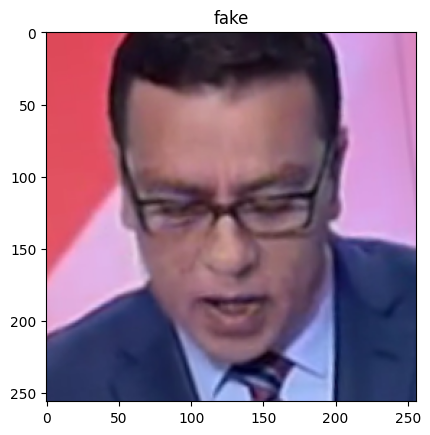

In [14]:
images, labels = next(iter(train_loader))
display_image(images[0], idx_to_class[labels[0].item()])

In [18]:
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [28]:
# [I 2024-12-23 01:29:01,081] Trial 14 finished with value: 0.735 and parameters: {'n_layers': 2, 'learning_rate': 0.002571768221420213, 'dropout_rate': 0.18647655711328523, 'n_units_l0': 1216, 'n_units_l1': 2005}. Best is trial 14 with value: 0.735.

dropout_rate = 0.186

classifier = torch.nn.Sequential(
    nn.Linear(512, 1216),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(1216, 2005),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(2005, 2),
    nn.LogSoftmax(dim=1),
)
classifier

Sequential(
  (0): Linear(in_features=512, out_features=1216, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.186, inplace=False)
  (3): Linear(in_features=1216, out_features=2005, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.186, inplace=False)
  (6): Linear(in_features=2005, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)

In [29]:
model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
if not os.path.exists("../checkpoints"):
    os.makedirs("../checkpoints")

In [35]:
latest_checkpoint_path = os.path.join("..", "checkpoints", "latest_model.pt")
best_checkpoint_path = os.path.join("..", "checkpoints", "best_model.pt")

# Loading the checkpoint and necessary stuff

In [121]:
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint["state_dict"])

# Hyper parameters

In [36]:
criterion = nn.NLLLoss()
epochs = 200
learning_rate = 0.0026
validate_every = 5

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
running_loss_array = []
valid_loss_array = []
epoch_array = []

In [39]:
validation_loss_min = np.inf
model.to(device)
model.train()

for e in range(epochs):
  running_loss = 0

  print(f"EPOCH {e + 1}:")
  i = 0
  for images, labels in tqdm.tqdm(train_loader):
    i += 1
    # print(f"{i} / {len(train_loader)} image being used for training")
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model.forward(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {e + 1} :: Running Loss: {running_loss / len(train_loader)}")

  current_model_state = {
    "state_dict": model.state_dict(),
    "valid_loss": validation_loss_min,
    "running_loss_array": running_loss_array,
    "valid_loss_array": valid_loss_array,
    "epoch_array": epoch_array,
    "number of epochs": e + 1,
  }

  validation_loss = 0

  if (e + 1) % validate_every == 0:
    epoch_array.append(e + 1)

    with torch.no_grad():
      model.eval()

      for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)

        validation_loss += loss.item()

      model.train()

    running_loss /= len(train_loader)
    validation_loss /= len(valid_loader)
    
    running_loss_array.append(running_loss)
    valid_loss_array.append(validation_loss)

    print(f"EPOCH {e + 1}:")
    print(f"Running Loss = {running_loss}\tValidation Loss: {validation_loss}")

    plot_double_line(epoch_array, running_loss_array, valid_loss_array, y1label="Running Loss", y2label="Validation Loss", xlab="Epochs", ylab="Loss")

    if validation_loss <= validation_loss_min:
      print(f"Minimum Validtion loss acquired, {validation_loss_min} to {validation_loss}")
      validation_loss_min = validation_loss
      current_model_state["valid_loss"] = validation_loss_min 
      torch.save(current_model_state, best_checkpoint_path)
  
  torch.save(current_model_state, latest_checkpoint_path)


EPOCH 1:


100%|██████████| 7783/7783 [28:33<00:00,  4.54it/s]


Epoch 1 :: Running Loss: 0.6947028818664125
EPOCH 2:


 15%|█▍        | 1151/7783 [04:13<24:22,  4.53it/s]


KeyboardInterrupt: 

# Metrics Calculation

In [20]:
validation_loss = 0
correct_valid = 0
total_valid = 0

with torch.no_grad():
    model.eval()

    for images, labels in tqdm.tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        logps = model.forward(images)
        loss = criterion(logps, labels)
        validation_loss += loss.item()

        # Calculate validation accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
        total_valid += labels.size(0)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100

print("Validation Accuracy:", validation_accuracy)

100%|██████████| 13/13 [00:02<00:00,  4.90it/s]

Validation Accuracy: 86.5


# Original Dataset Validation Accuracy

In [21]:
original_valid_set = ImageFolder("./dataset/DFWild-Cup/valid", transform=test_transforms)
original_valid_loader = DataLoader(original_valid_set, batch_size=batch_size)

In [22]:
original_valid_set.class_to_idx

{'fake': 0, 'real': 1}

In [23]:
from PIL import UnidentifiedImageError
corrupted_files = []

In [24]:
validation_loss = 0
correct_valid = 0
total_valid = 0

model.to(device)

with torch.no_grad():
    model.eval()

    try:
        for images, labels in tqdm.tqdm(original_valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            logps = model.forward(images)
            loss = criterion(logps, labels)
            validation_loss += loss.item()

            # Calculate validation accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            correct_valid += (top_class == labels.view(*top_class.shape)).sum().item()
            total_valid += labels.size(0)
    except UnidentifiedImageError as e:
        corrupted_files.append(e)

validation_loss /= len(valid_loader)
validation_accuracy = correct_valid / total_valid * 100
model.train()

print("Validation Accuracy:", validation_accuracy)

100%|██████████| 192/192 [01:16<00:00,  2.50it/s]

Validation Accuracy: 50.390625


# Testing the model with images

In [21]:
from PIL import Image

In [57]:
image_path = "image5.jpg"
image = Image.open(image_path).convert("RGB")
input_tensor = test_transforms(image).unsqueeze(0)

model.to(device)
model.eval()
input_tensor = input_tensor.to(device)

with torch.no_grad():
    output = model(input_tensor)

model.train()
output = torch.exp(output)
print("Output:", output)
predicted_class = torch.argmax(output, dim=1)
prediction = predicted_class.item()
print("Prediction:", idx_to_class[prediction])

Output: tensor([[1.4013e-45, 1.0000e+00]], device='cuda:0')
Prediction: real
